In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

In [33]:
df = sns.load_dataset("titanic")


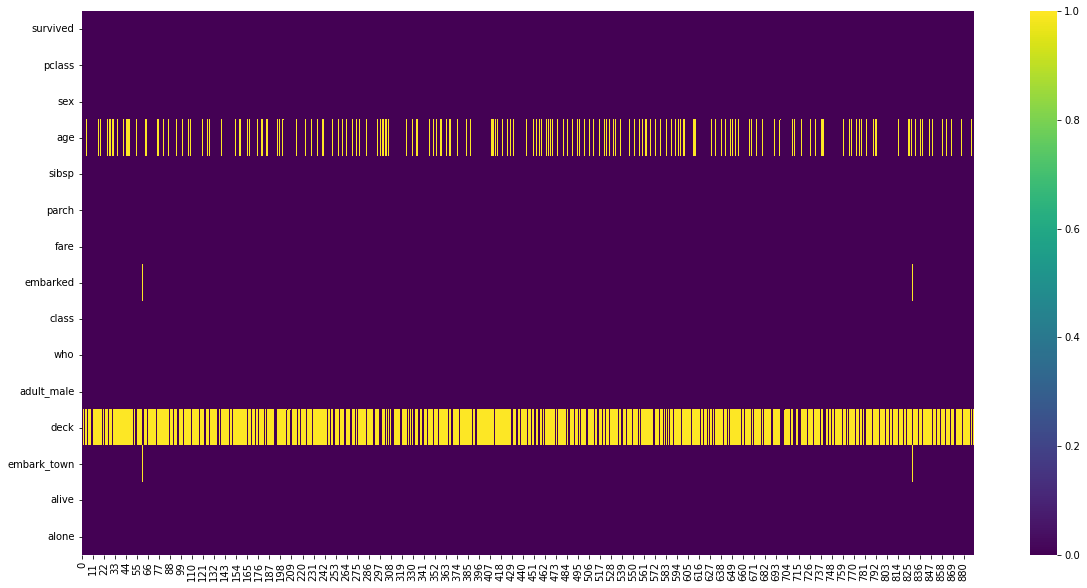

In [34]:
# Yellow lines are nan values
nan_values_transpose = df.isna().transpose().copy()
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(nan_values_transpose, ax = ax, cmap = "viridis")
plt.show()



In [35]:
df.drop(["deck"], axis = 1, inplace = True)

# drop useless columns 
df.drop(["who","class","adult_male","embarked","alive","alone"], axis = 1, inplace = True)


In [36]:
# category to boolian
df["sex"] = np.where(df.sex == "female", 1, 0)


In [37]:
# check correlation for age column
df.corr()["age"].sort_values()


pclass     -0.369226
sibsp      -0.308247
parch      -0.189119
sex        -0.093254
survived   -0.077221
fare        0.096067
age         1.000000
Name: age, dtype: float64

In [38]:
# check age depend on pclass
pclass_age = df.groupby(["pclass"])["age"].agg(["mean", "median","min","max","count"])
pclass_age


,mean,median,min,max,count
pclass,,,,,
1,38.233441,37.0,0.92,80.0,186
2,29.877630,29.0,0.67,70.0,173
3,25.140620,24.0,0.42,74.0,355


In [39]:
# check age depend on sibsp
sibsp_age = df.groupby(["sibsp"])["age"].agg(["mean", "median","min","max","count"])
sibsp_age


,mean,median,min,max,count
sibsp,,,,,
0,31.397558,29.0,0.42,80.0,471
1,30.089727,30.0,0.67,70.0,183
2,22.620000,23.0,0.75,53.0,25
3,13.916667,9.5,2.00,33.0,12
4,7.055556,6.5,1.00,17.0,18
5,10.200000,11.0,1.00,16.0,5
8,NaN,NaN,NaN,NaN,0


In [40]:
# check age depend on sibsp and pclass
pclass_sibsp_age = df.groupby(["pclass","sibsp"])["age"].agg(["mean", "median","min","max","count"])
pclass_sibsp_age


mean  median    min   max  count
pclass sibsp                                       
1      0      39.181416    37.0   4.00  80.0    113
       1      37.414154    38.0   0.92  70.0     65
       2      37.200000    44.0  18.00  53.0      5
       3      22.000000    23.0  19.00  24.0      3
2      0      31.934220    30.0   0.83  70.0    109
       1      27.363636    29.0   0.67  60.0     55
       2      19.125000    23.5   1.00  32.0      8
       3      30.000000    30.0  30.00  30.0      1
3      0      27.630201    26.0   0.42  74.0    249
       1      24.912698    25.0   1.00  48.0     63
       2      18.875000    19.5   0.75  41.0     12
       3       8.875000     6.0   2.00  33.0      8
       4       7.055556     6.5   1.00  17.0     18
       5      10.200000    11.0   1.00  16.0      5
       8            NaN     NaN    NaN   NaN      0

In [41]:
df.age.mean()


29.69911764705882

In [42]:
# map function 
def fill_nan_age(x):
    if (x == 0):
        return 32
    elif (x == 1):
        return 30
    elif (x == 2):
        return 23
    elif (x == 3):
        return 14
    elif (x == 4):
        return 7
    elif (x == 5):
        return 10
    else:
        return 30


In [43]:
# mapping. fill age's nan value with map function above
df["age"] = df.apply(lambda x : fill_nan_age(x.sibsp) if pd.isnull(x.age) else x.age, axis = 1 )


In [44]:
# drop rows which has nan values
df = df.dropna().reset_index(drop = True)


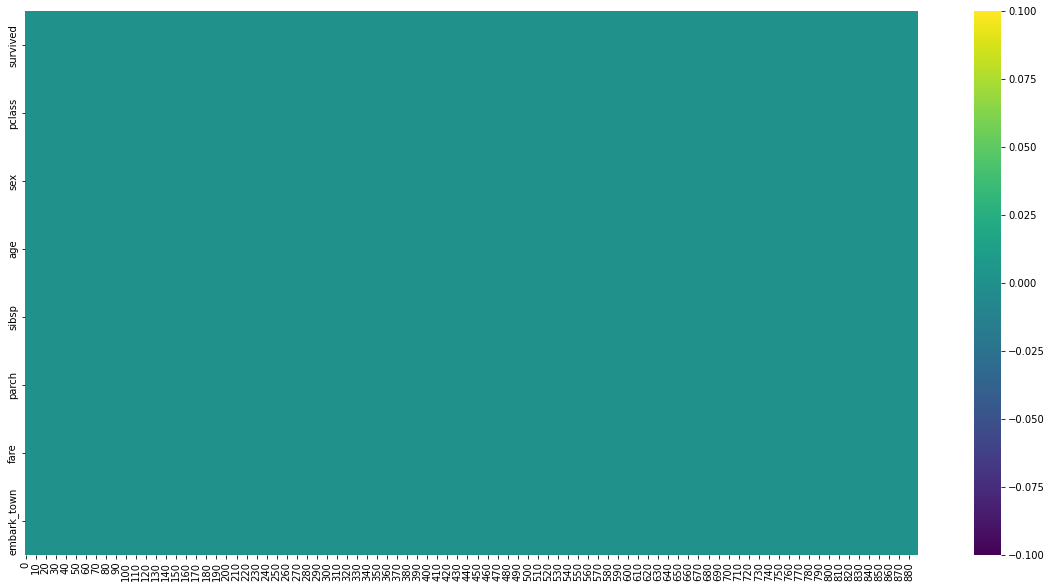

In [45]:
# nan values heatmap
nan_values_transpose_final = df.isna().transpose().copy()
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(nan_values_transpose_final, ax = ax, cmap = "viridis")
plt.show()


In [46]:
# category to boolian
df = pd.get_dummies(df, columns = ["embark_town"], drop_first = True)


In [47]:
# check correlation for survived (target column)
df.corr()["survived"].sort_values(ascending = False)

survived                   1.000000
sex                        0.541585
fare                       0.255290
parch                      0.083151
embark_town_Queenstown     0.004536
sibsp                     -0.034040
age                       -0.077954
embark_town_Southampton   -0.151777
pclass                    -0.335549
Name: survived, dtype: float64

In [48]:
# check relation between fare,survived, sex and pclass 
scatter = px.scatter(df, x = "fare", y = "survived", color = "sex", size = "pclass")
scatter.show()

In [49]:
# cut the target column
y = df["survived"]
X = df.drop(["survived"], axis = 1)


In [50]:
# NN model 
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(100, input_shape =(X_train.shape[1],), activation = "relu" ))
    model.add(tf.keras.layers.Dense(20, activation = "relu" ))
    model.add(tf.keras.layers.Dense(1, activation = "sigmoid" ))
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"] )
    return model

In [51]:

# create a list to compare result of each model at the end
models_result = []

# estimate score of each model by using different random states. At the end mean is important.
scores_nn = []
score_lgreg = []
score_rfc = []
score_svc = []

for i in range(10):
    # spliting
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = i)
    
    # Normalization

    age_scaler = MinMaxScaler()
    fare_scaler = MinMaxScaler()

    age_scaler.fit(np.reshape(X_train.age.values,(-1,1)))
    X_train["age"] = np.squeeze(age_scaler.transform(np.reshape(X_train.age.values,(-1,1))))
    X_test["age"] = np.squeeze(age_scaler.transform(np.reshape(X_test.age.values,(-1,1))))


    fare_scaler.fit(np.reshape(X_train.fare.values,(-1,1)))
    X_train["fare"] = np.squeeze(fare_scaler.transform(np.reshape(X_train.fare.values,(-1,1))))
    X_test["fare"] = np.squeeze(fare_scaler.transform(np.reshape(X_test.fare.values,(-1,1))))

    # NN
    # build model
    model_nn = build_model()
    # fit model
    model_nn.fit(X_train,y_train, epochs = 5000, batch_size = 32, verbose = False)
    prediction_nn = model_nn.predict(X_test)
    prediction_nn_final = np.where(prediction_nn > 0.5, 1,0)
    score_nn_i = f1_score(y_test,prediction_nn_final, average = "weighted" )
    scores_nn.append(score_nn_i)

    # LogisticRegression
    lgreg = LogisticRegression(max_iter = 200)
    lgreg.fit(X_train, y_train)
    prediction_lgreg = lgreg.predict(X_test)
    score_lgreg_i = f1_score(y_test,prediction_lgreg, average = "weighted" )
    score_lgreg.append(score_lgreg_i)

    # RandomForest
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    prediction_rfc = rfc.predict(X_test)
    score_rfc_i = f1_score(y_test,prediction_rfc, average = "weighted" )
    score_rfc.append(score_rfc_i)

    # SVC
    svc = SVC()
    svc.fit(X_train, y_train)
    prediction_svc = svc.predict(X_test)
    score_svc_i = f1_score(y_test,prediction_svc, average = "weighted" )
    score_svc.append(score_svc_i)

models_result.append(["NN", np.mean(scores_nn)])
models_result.append(["LogisticRegression", np.mean(score_lgreg)])
models_result.append(["RandomForest", np.mean(score_rfc)])
models_result.append(["SVC", np.mean(score_svc)])


6/6 [==============================] - 0s 2ms/step


In [52]:
# create dataframe based on models and scores 
compare_df = pd.DataFrame(models_result, columns = ["model","score"])

In [53]:
# convert scores to percentage and then round them.
compare_df["score"] = (compare_df["score"] * 100).round(2)

In [54]:
# Based on weighted f1-score (main measure for models) can see which model did best on titanic dataset
compare_df.sort_values(["score"], ascending = False)

,model,score
3,SVC,80.09
2,RandomForest,80.07
1,LogisticRegression,79.34
0,NN,78.25


In [58]:
# Author: amyrmahdy
# Date: 4 Dec 2022